
# Generación de música con RNN


En este programa exploraremos la construcción de una red neuronal recurrente (RNN) para la generación de música. Entrenaremos un modelo para aprender los patrones en partituras sin procesar en [ABC notation](https://en.wikipedia.org/wiki/ABC_notation) y luego usaremos este modelo para generar nueva música.

Instalemos las dependencias e importemos los paquetes relevantes que necesitaremos para este laboratorio.

In [1]:
# Importar Tensorflow 2.0
%tensorflow_version 2.x
import tensorflow as tf 

# Importar the MIT 6.S191 package
!pip install mitdeeplearning
import mitdeeplearning as mdl

# Importar otros paquetes
import numpy as np
import os
import time
import functools
from IPython import display as ipythondisplay
from tqdm import tqdm
!apt-get install abcmidi timidity > /dev/null 2>&1

# Usar un GPU
assert len(tf.config.list_physical_devices('GPU')) > 0

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Dataset

![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)

Hemos recopilado un conjunto de datos de miles de canciones populares irlandesas, representadas en la notación ABC. Descarguemos el conjunto de datos e inspeccionémoslo:

In [2]:
# Bajar dataset
songs = mdl.lab1.load_training_data()

# Imprimir una cancion!
example_song = songs[0]
print("\nEjemplo de musica: ")
print(example_song)

Found 817 songs in text

Ejemplo de musica: 
X:1
T:Alexander's
Z: id:dc-hornpipe-1
M:C|
L:1/8
K:D Major
(3ABc|dAFA DFAd|fdcd FAdf|gfge fefd|(3efe (3dcB A2 (3ABc|!
dAFA DFAd|fdcd FAdf|gfge fefd|(3efe dc d2:|!
AG|FAdA FAdA|GBdB GBdB|Acec Acec|dfaf gecA|!
FAdA FAdA|GBdB GBdB|Aceg fefd|(3efe dc d2:|!


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Podemos convertir fácilmente una canción en notación ABC a una forma de onda de audio y reproducirla. Eso toma tiempo

In [ ]:
# Convertir la ABC notation a un archivo de audio y escucharlo
mdl.lab1.play_song(example_song)

Esta notación de música no solo contiene información sobre las notas que se están reproduciendo, sino que además hay metainformación como el título, la clave y el tempo de la canción. 

In [ ]:
# Juntar cadenas de canciones en una unica cadena con todas las canciones
songs_joined = "\n\n".join(songs) 

# Buscar caracteres unicos en la cadena nueva
vocab = sorted(set(songs_joined))
print("Hay", len(vocab), "caracteres unicos en el dataset")

Hay 83 caracteres unicos en el dataset


## Procesar el conjunto de datos para la tarea de aprendizaje

Estamos tratando de entrenar un modelo RNN para aprender patrones en la música ABC y luego usar este modelo para generar (es decir, predecir) una nueva pieza musical basada en esta información aprendida.

Desglosando esto, lo que realmente le estamos preguntando al modelo es: dado un caracter (nota musical), o una secuencia de ellos, ¿cuál es el próximo más probable? Entrenaremos el modelo para realizar esta tarea.

Para lograr esto, ingresaremos una secuencia de caracteres en el modelo y entrenaremos el modelo para predecir la salida, es decir, el siguiente carácter en cada paso de tiempo. Los RNN mantienen un estado interno que depende de los elementos vistos anteriormente, por lo que la información sobre todos los caracteres vistos hasta un momento dado se tendrá en cuenta para generar la predicción.

### Vectorizar el texto

Antes de comenzar a entrenar nuestro modelo RNN, necesitaremos crear una representación numérica de nuestro conjunto de datos basado en texto. Para hacer esto, generaremos dos tablas de búsqueda: una que asigna caracteres a números y una segunda que asigna números a caracteres. 

In [ ]:
### Definir representacion  numerica del texto ###

# Crear un mapeo desde caracteres a un unico indice
# Por ejemplo, para el indice del caracter "d", 
#   calcular `char2idx["d"]`.  
char2idx = {u:i for i, u in enumerate(vocab)}

# Crear un mapeo desde indices a caracteres. Es el00
#   inverso de char2idx y convierte desde el
#   unico indice al caracter en nuestro vocabulario.
idx2char = np.array(vocab)

Esto nos da una representación entera para cada carácter. Observe que los caracteres únicos (es decir, nuestro vocabulario) en el texto están mapeados como índices de 0 a `len(unique)`. Echemos un vistazo a esta representación numérica de nuestro conjunto de datos:

In [ ]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '"' :   3,
  '#' :   4,
  "'" :   5,
  '(' :   6,
  ')' :   7,
  ',' :   8,
  '-' :   9,
  '.' :  10,
  '/' :  11,
  '0' :  12,
  '1' :  13,
  '2' :  14,
  '3' :  15,
  '4' :  16,
  '5' :  17,
  '6' :  18,
  '7' :  19,
  ...
}


In [ ]:
### Vectorizar las cadenas de canciones ###

'''TODO: funcion para convertir cadena de canciones a una representacion de vector
    (p.e., numerico). Usar el apropiado mapeo
    
  NOTE: la salida de la funcion `vectorize_string`  
  es un np.array con `N` elementos, donde `N` es
  el numero de caracteres en la cadena de entrada
'''
def vectorize_string(string):
  vectorized_output = np.array([char2idx[char] for char in string])
  return vectorized_output

# def vectorize_string(string):
  # TODO

vectorized_songs = vectorize_string(songs_joined)

También podemos ver cómo se asigna la primera parte del texto a una representación entera::

In [ ]:
print ('{} ---- caracteres mapeados a int ----> {}'.format(repr(songs_joined[:10]), vectorized_songs[:10]))
# chequeo que vectorized_songs es un numpy array
assert isinstance(vectorized_songs, np.ndarray), "resultado debe ser un numpy array"

'X:1\nT:Alex' ---- caracteres mapeados a int ----> [49 22 13  0 45 22 26 67 60 79]


### Crear ejemplos de entrenamiento

Dividir el texto en secuencias de ejemplo que usaremos durante el entrenamiento. Cada secuencia de entrada que alimentamos a nuestro RNN contendrá caracteres `seq_length` del texto. También necesitaremos definir una secuencia objetivo para cada secuencia de entrada, que se utilizará en el entrenamiento del RNN para predecir el siguiente carácter. Para cada entrada, la secuencia objetivo correspondiente contendrá la misma longitud de texto, excepto que se desplazó un carácter a la derecha.

Para hacer esto, dividiremos el texto en trozos de `seq_length+1`. Suponga que `seq_length` es 4 y nuestro texto es "Correr". Entonces, nuestra secuencia de entrada es "Corr" y la secuencia objetivo es "orre".

El método por lotes nos permitirá convertir este flujo de índices de caracteres en secuencias del tamaño deseado.

In [ ]:
### Definicion del lote de ejemplos de entrenamiento ###

def get_batch(vectorized_songs, seq_length, batch_size):
  # Longitud de la cadena vectorized songs
  n = vectorized_songs.shape[0] - 1
  # Escoger aleatoriamente el indice del punto de inicio para los ejemplos en el lote de entrenamiento
  idx = np.random.choice(n-seq_length, batch_size)

  '''TODO: construct a list of input sequences for the training batch'''
  input_batch = [vectorized_songs[i : i+seq_length] for i in idx]
  # Entrada_batch = # TODO
  '''TODO: construct a list of output sequences for the training batch'''
  output_batch = [vectorized_songs[i+1 : i+seq_length+1] for i in idx]
  # Salida_batch = # TODO

  # x_batch, y_batch provee la entrada y salida para entrenamiento
  x_batch = np.reshape(input_batch, [batch_size, seq_length])
  y_batch = np.reshape(output_batch, [batch_size, seq_length])
  return x_batch, y_batch


# hacer algunas pruebas para estar seguro que la funcion batch  es correcta 
test_args = (vectorized_songs, 10, 2)
if not mdl.lab1.test_batch_func_types(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_shapes(get_batch, test_args) or \
   not mdl.lab1.test_batch_func_next_step(get_batch, test_args): 
   print("======\n[FAIL] could not pass tests")
else: 
   print("======\n[PASS] passed all tests!")

[PASS] test_batch_func_types
[PASS] test_batch_func_shapes
[PASS] test_batch_func_next_step
[PASS] passed all tests!


Para cada uno de estos vectores, cada índice se procesa en un solo paso de tiempo. Entonces, para la entrada en el paso de tiempo 0, el modelo recibe el índice del primer carácter de la secuencia e intenta predecir el índice del siguiente carácter. En el siguiente paso de tiempo, hace lo mismo, pero el RNN considera la información del paso anterior, es decir, su estado actualizado, además de la entrada actual.

Podemos hacer esto concreto al observar cómo funciona esto con los primeros caracteres de nuestro texto:

In [ ]:
x_batch, y_batch = get_batch(vectorized_songs, seq_length=5, batch_size=1)

for i, (input_idx, target_idx) in enumerate(zip(np.squeeze(x_batch), np.squeeze(y_batch))):
    print("Step {:3d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step   0
  input: 82 ('|')
  expected output: 62 ('g')
Step   1
  input: 62 ('g')
  expected output: 14 ('2')
Step   2
  input: 14 ('2')
  expected output: 57 ('b')
Step   3
  input: 57 ('b')
  expected output: 62 ('g')
Step   4
  input: 62 ('g')
  expected output: 1 (' ')


## 2.4 Recurrent Neural Network (RNN)


Ahora estamos listos para entrenar un modelo RNN con el conjunto de datos de música ABC, y luego usar ese modelo entrenado para generar una nueva canción. Entrenaremos a nuestro RNN usando lotes de fragmentos de canciones del conjunto de datos, que generamos en la sección anterior.

El modelo se basa en la arquitectura LSTM, donde usamos un vector de estado para mantener información sobre las relaciones temporales entre caracteres consecutivos. La salida final del LSTM luego se alimenta a una capa  [`Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)  completamente conectada donde generaremos un softmax sobre cada carácter en el vocabulario, y luego tomaremos una muestra de esta distribución para predecir el siguiente carácter.

Usaremos [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Sequential) para definir el modelo utilizanso tres capas:

* [`tf.keras.layers.Embedding`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding): Esta es la capa de entrada, que consta de una tabla de búsqueda entrenable que asigna los números de cada carácter a un vector con dimensiones `embedding_dim`
* [`tf.keras.layers.LSTM`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM): Nuestra red LSTM, con tamaño `units=rnn_units`. 
* [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense): La capa de salida, con `vocab_size` salidas.


<img src="https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_unrolled-01-01.png" alt="Drawing"/>

### Definir el modelo RNN



In [ ]:
def LSTM(rnn_units): 
  return tf.keras.layers.LSTM(
    rnn_units, 
    return_sequences=True, 
    recurrent_initializer='glorot_uniform',
    recurrent_activation='sigmoid',
    stateful=True,
  )

Ahora hay que completar toda la cadena `TODOs` para definir el modelo RNN dentro de la función `build_model`, y con esa función  acaba de definir para crear una instancia del modelo

In [ ]:
### Definiendo la RNN ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Capa 1: capa de incrustación para transformar índices en vectores densos 
    #   de fijo tamano
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Capa 2: LSTM con `rnn_units` numero de unidades. 
    # TODO: llamar la funcion LSTM definida antes para agregar esta capa.
    LSTM(rnn_units), 
    # LSTM('''TODO'''),

    # Capa 3: Capa Densa (toda-conectada) que transforma la salida de LSTM 
    #   en el vocabulario. 
    # TODO: Agrega la capa Densa.
    tf.keras.layers.Dense(vocab_size)
    # '''TODO: DENSE LAYER HERE'''
  ])

  return model

# Construir un modelo  hiperparametros por defecto

model = build_model(len(vocab), embedding_dim=256, rnn_units=1024, batch_size=32)

### Pruebas al modelo RNN

Primero, podemos usar la función `Model.summary` para imprimir un resumen del funcionamiento interno de nuestro modelo. Aquí podemos comprobar las capas en el modelo, la forma de la salida de cada una de las capas, el tamaño del lote, etc.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (32, None, 256)           21248     
                                                                 
 lstm (LSTM)                 (32, None, 1024)          5246976   
                                                                 
 dense (Dense)               (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


También podemos comprobar rápidamente la dimensionalidad de nuestra salida, utilizando una longitud de secuencia de 100. Tenga en cuenta que el modelo se puede ejecutar en entradas de cualquier longitud.

In [ ]:
x, y = get_batch(vectorized_songs, seq_length=100, batch_size=32)
pred = model(x)
print("Entrada:      ", x.shape, " # (batch_size, sequence_length)")
print("Prediccion: ", pred.shape, "# (batch_size, sequence_length, vocab_size)")

Entrada:       (32, 100)  # (batch_size, sequence_length)
Prediccion:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)


### Predicciones

Veamos que predice nuestro modelo no capacitado.

Para obtener predicciones reales del modelo, tomamos muestras de la distribución de salida, que está definida por un softmax sobre nuestro vocabulario de caracteres. Esto nos dará índices de caracteres reales. Esto significa que estamos usando una [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) para muestrear la predicción del ejemplo. Esto da una predicción del siguiente carácter (específicamente su índice) en cada paso de tiempo.

Tenga en cuenta aquí que tomamos muestras de esta distribución de probabilidad, en lugar de simplemente tomar el argmax, lo que puede hacer que el modelo se atasque en un bucle.

Probemos este muestreo para el primer ejemplo del lote.

In [ ]:
sampled_indices = tf.random.categorical(pred[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()
sampled_indices

array([33, 47, 61, 49,  5, 73, 44, 36, 70, 23, 32, 49, 32,  6, 36, 79, 41,
       42, 11,  9, 60, 25, 28, 29, 65,  6,  9, 11, 26, 29, 58, 54, 81, 67,
       64, 32, 30, 27, 62, 18, 48, 29, 16, 78, 75, 81, 21,  7, 80, 38, 21,
       48, 55, 36, 54, 49, 79, 70, 68, 13, 21, 56, 13, 82, 42, 57, 24,  6,
       15,  5, 56, 35, 69, 18, 45, 44,  6, 23, 74, 75, 32, 10, 16, 58, 58,
       25,  6, 57, 12, 20, 15, 64, 34, 35, 26, 48, 25,  0, 68, 25])

Ahora podemos decodificarlos para ver el texto predicho por el modelo no entrenado:

In [ ]:
print("Entrada: \n", repr("".join(idx2char[x[0]])))
print()
print("Predicciones del proximo Caracter: \n", repr("".join(idx2char[sampled_indices])))

Entrada: 
 '|!\nBedB A2BA|G2AG EAGE|DB,B,2 DEGA|BdAF G:|!\nABc|d2Bd cBAF|G2BG AGEG|DGG2 eGdG|cBAG FGAB|!\ncBce dBAG'

Predicciones del proximo Caracter: 
 "HVfX'rSKo<GXG(KxPQ/-e>CDj(-/ADc^zliGEBg6WD4wtz9)yM9W_K^Xxom19a1|Qb=(3'aJn6TS(<stG.4cc>(b083iIJAW>\nm>"


Como puede ver, el texto predicho por el modelo no entrenado es bastante absurdo. ¿Cómo podemos hacerlo mejor? ¡Podemos entrenar la red!

## Entrenando el modelo:

Podemos pensar en nuestro próximo problema de predicción de caracteres como un problema de clasificación estándar. Dado el estado anterior del RNN, así como la entrada en un intervalo de tiempo determinado, queremos predecir la clase del siguiente carácter, es decir, predecir realmente el próximo carácter.

Para entrenar nuestro modelo en esta tarea de clasificación, podemos usar una forma de pérdida de `crossentropy` (pérdida de probabilidad logarítmica negativa). Específicamente, usaremos la pérdida [`sparse_categorical_crossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy), ya que utiliza objetivos enteros para tareas de clasificación categórica. Querremos calcular la pérdida utilizando los verdaderos objetivos, las `labels` , y los objetivos predichos, los `logits`.

Primero calculemos la pérdida usando nuestras predicciones de ejemplo del modelo no capacitado:

In [ ]:
### Definir la funcion de perdida ###

'''TODO: definir la funcion de perdida para calcular la perdida entre
    las verdaderas etiquetas y predicciones (logits). El argumento from_logits=True.'''
def compute_loss(labels, logits):
  loss = tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)
  # loss = tf.keras.losses.sparse_categorical_crossentropy('''TODO''', '''TODO''', from_logits=True) # TODO
  return loss

'''TODO: calcular la perdida usando el siguiente correcto caracter desde el lote de ejemplos 
    y la prediccioness desde el modelo no entrenado con algunas celdas anteriores'''
example_batch_loss = compute_loss(y, pred)
# example_batch_loss = compute_loss('''TODO''', '''TODO''') # TODO

print("Prediccion: ", pred.shape, " # (batch_size, sequence_length, vocab_size)") 
print("Perdida:      ", example_batch_loss.numpy().mean())

Prediccion:  (32, 100, 83)  # (batch_size, sequence_length, vocab_size)
Perdida:       4.418123



Comencemos por definir algunos hiperparámetros para entrenar el modelo. Para empezar, hemos proporcionado algunos valores razonables para algunos de los parámetros

In [ ]:
### Determinacion Hiperparametros y optimizacion ###

# Optimizacion de los parametros:
num_training_iterations = 2000  # Increase this to train longer
batch_size = 4  # Experimento entre 1 y 64
seq_length = 100  # Experimento entre 50 y 500
learning_rate = 5e-3  # Experimento entre 1e-5 y 1e-1

# Parametros del Modelo: 
vocab_size = len(vocab)
embedding_dim = 256 
rnn_units = 1024  # Experimento entre 1 y 2048

# locacion del punto de Chequeo: 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "my_ckpt")


Ahora, estamos listos para definir nuestra operación de entrenamiento (el optimizador y la duración del entrenamiento) y usar esta función para entrenar el modelo. Experimentarás con la elección del optimizador y la duración durante la cual entrenas tus modelos, y verás cómo estos cambios afectan la salida de la red. Algunos optimizadores podrían ser  [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam?version=stable) y [`Adagrad`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adagrad?version=stable).

Primero, crearemos una instancia de un nuevo modelo y un optimizador. Luego, usaremos el método [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) para realizar las operaciones de retropropagación.

También generaremos una impresión del progreso del modelo a través del entrenamiento, que nos ayudará a visualizar fácilmente si estamos minimizando o no la pérdida.

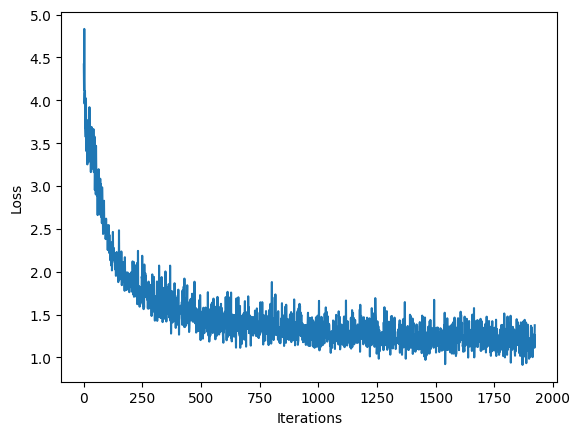

100%|██████████| 2000/2000 [01:07<00:00, 29.43it/s]


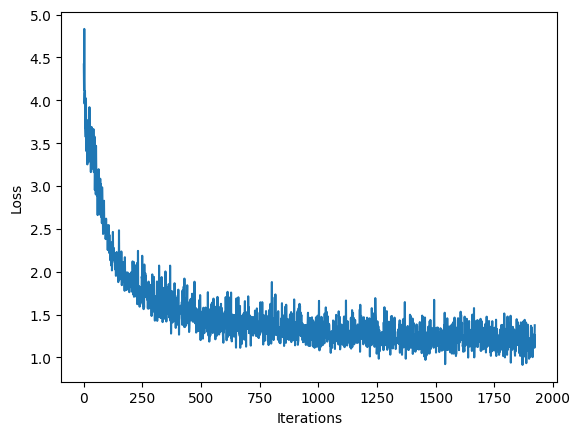

In [ ]:
### Definir optimizer y operacion de entrenamiento ###

'''TODO: instanciar un nuevo modelo para entranar usando la funcion `build_model`
  y los hiperparametros anteriores.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# model = build_model('''TODO: arguments''')

'''TODO: instanciar un optimizer con su tasa de aprendizaje.
  una lista de optimizadores estan en:
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Usemos Adam optimizer para comenzar.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = # TODO

@tf.function
def train_step(x, y): 
  # Usar tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: alimentar actual entrada en el modelo para generar predicciones'''
    y_hat = model(x) # TODO
    # y_hat = model('''TODO''')
  
    '''TODO: calcular perdida!'''
    loss = compute_loss(y, y_hat) # TODO
    # loss = compute_loss('''TODO''', '''TODO''')

  # Calcular gradientes 
  '''TODO: completar la llamada a la funcion calculando gradiente
      HINT: use `model.trainable_variables` para tener una lista de todos
      los parametros del modelo.'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  # grads = tape.gradient('''TODO''', '''TODO''')
  
  # Aplicar  los gradientes al optimizerpara actualizar el modelo
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Comenzar a entrenar!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Tome un lote y propaguelo a través de la red
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Actualizar la barra de progreso
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Actualizar el modelo con los pesos cambiados!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Guarde el modelo entrenado y los pesos
model.save_weights(checkpoint_prefix)


## Genera música usando el modelo RNN

¡Ahora, podemos usar nuestro modelo RNN entrenado para generar algo de música! Al generar música, tendremos que alimentar el modelo con algún tipo de semilla para que comience (¡porque no puede predecir nada sin algo para comenzar!).

Una vez que tenemos una semilla generada, podemos predecir iterativamente cada carácter sucesivo (recuerde, estamos usando la representación ABC para nuestra música) usando nuestro RNN entrenado. Más específicamente, recuerde que nuestro RNN genera un softmax sobre posibles caracteres sucesivos. Para la inferencia, tomamos muestras iterativas de estas distribuciones y luego usamos nuestras muestras para codificar una canción generada en el formato ABC.

Entonces, ¡todo lo que tenemos que hacer es escribirlo en un archivo y escuchar! 

### Restaurar el último punto de control

Restaurar el último punto de control
Para mantener este paso de inferencia simple, usaremos un tamaño de lote de 1. Debido a cómo se pasa el estado RNN de un paso de tiempo a otro, el modelo solo podrá aceptar un tamaño de lote fijo una vez que esté construido.

Para ejecutar el modelo con un tamaño de lote diferente, necesitaremos reconstruir el modelo y restaurar los pesos desde el último punto de control, es decir, los pesos después del último punto de control durante el entrenamiento:

In [ ]:
'''TODO: Reconstruya el modelo usando un batch_size=1'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) # TODO
# model = build_model('''TODO''', '''TODO''', '''TODO''', batch_size=1)

# Restaurar los pesos del modelo para el último punto de control después del entrenamiento
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (1, None, 256)            21248     
                                                                 
 lstm_2 (LSTM)               (1, None, 1024)           5246976   
                                                                 
 dense_2 (Dense)             (1, None, 83)             85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________


Observe que hemos introducido un `batch_size` de 1 para la inferencia.

### Procedimiento de predicción

Ahora, estamos listos para escribir el código para generar texto en el formato de música ABC:

* Inicialice una cadena de inicio "semilla" y el estado RNN, y establezca el número de caracteres que queremos generar.

* Utilice la cadena de inicio y el estado RNN para obtener la distribución de probabilidad sobre el siguiente carácter predicho.

* Muestra de la distribución multinomial para calcular el índice del carácter predicho. Este carácter predicho se utiliza luego como la siguiente entrada al modelo.

* En cada paso de tiempo, el estado RNN actualizado se retroalimenta en el modelo, de modo que ahora tiene más contexto para realizar la próxima predicción. Después de predecir el siguiente carácter, los estados RNN actualizados se retroalimentan nuevamente en el modelo, que es la forma en que aprende las dependencias de secuencia en los datos, a medida que obtiene más información de las predicciones anteriores.

![LSTM inference](https://raw.githubusercontent.com/aamini/introtodeeplearning/2019/lab1/img/lstm_inference.png)

Complete y experimente con este bloque de código (¡así como con algunos de los aspectos de la definición y el entrenamiento de la red!), y vea cómo funciona el modelo. ¿Cómo se comparan las canciones generadas después del entrenamiento con un pequeño número de épocas con las generadas después de un entrenamiento de mayor duración?

In [ ]:
### Predicción de una canción generada ###

def generate_text(model, start_string, generation_length=1000):
  # Paso de evaluación (generar texto ABC utilizando el modelo RNN aprendido)

  '''TODO: convertir la cadena de inicio en números (vectorizar)'''
  input_eval = [char2idx[s] for s in start_string] # TODO
  # input_eval = ['''TODO''']
  input_eval = tf.expand_dims(input_eval, 0)

  # Cadena vacía para almacenar nuestros resultados
  text_generated = []

  # Aqui batch size == 1
  model.reset_states()
  tqdm._instances.clear()

  for i in tqdm(range(generation_length)):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      predictions = model(input_eval)
      # prediccions = model('''TODO''')
      
      # Remover la  dimension batch
      predictions = tf.squeeze(predictions, 0)
      
      '''TODO: use a multinomial distribution to sample'''
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()
      # predicted_id = tf.random.categorical('''TODO''', num_samples=1)[-1,0].numpy()
      
      # Pasa la predicción junto con el estado oculto anterior
      #   como las próximas entradas al modelo
      input_eval = tf.expand_dims([predicted_id], 0)
      
      '''TODO: agregue el carácter predicho al texto generado!'''
      # Sugerencia: considere en qué formato está la predicción frente a la salida
      text_generated.append(idx2char[predicted_id]) # TODO 
      # text_generated.append('''TODO''')
    
  return (start_string + ''.join(text_generated))

In [ ]:
'''TODO: Utilice el modelo y la función definidos anteriormente para generar texto en formato ABC de longitud 1000!
    Como puede notar, los archivos ABC comienzan con "X" - esta puede ser una buena cadena de inicio.'''
generated_text = generate_text(model, start_string="X", generation_length=1000) # TODO
# generated_text = generate_text('''TODO''', start_string="X", generation_length=1000)

100%|██████████| 1000/1000 [00:11<00:00, 88.37it/s]


### ¡Reproduce la música generada!

¡Ahora podemos llamar a una función para convertir el texto en formato ABC en un archivo de audio, y luego reproducirlo para ver nuestra música generada! 

In [ ]:
### Reproducir canciones generadas ###

generated_songs = mdl.lab1.extract_song_snippet(generated_text)

for i, song in enumerate(generated_songs): 
  # Sintetizar la forma de onda de una canción
  waveform = mdl.lab1.play_song(song)

  # Si es una canción válida (sintaxis correcta), reproduzcamos! 
  if waveform:
    print("Generated song", i)
    ipythondisplay.display(waveform)

## Tareas

1) Use otro optimizador y otras duraciones para entrenar el modelo e indique los cambios que se producen.

2) Cambien tambien la dimensionalidad de la RNN y los hiperparametros e indique que ocurre con la calidad de los resultados

2) Intente entrenar más tiempo si la canción resultante no es lo suficientemente larga, ¡o vuelva a generar la canción!



![Let's Dance!](http://33.media.tumblr.com/3d223954ad0a77f4e98a7b87136aa395/tumblr_nlct5lFVbF1qhu7oio1_500.gif)



#1
Cambio de optimizador (se vuelve a ejecutar todo menos la celda del optimizador anterior, en cambio se ejecutara esta celda)

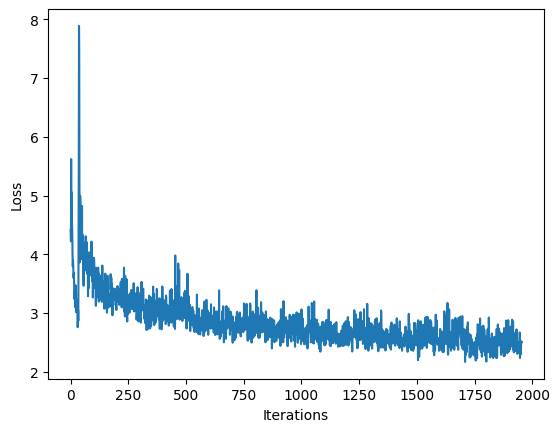

100%|██████████| 2000/2000 [01:03<00:00, 31.52it/s]


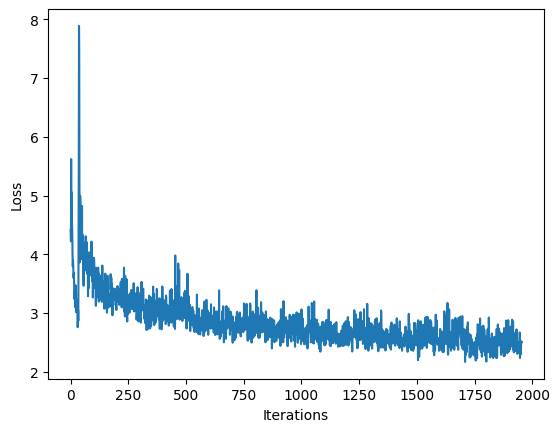

In [ ]:
### Definir optimizer y operacion de entrenamiento ###

'''TODO: instanciar un nuevo modelo para entranar usando la funcion `build_model`
  y los hiperparametros anteriores.'''
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size)
# model = build_model('''TODO: arguments''')

'''TODO: instanciar un optimizer con su tasa de aprendizaje.
  una lista de optimizadores estan en:
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Usemos Adam optimizer para comenzar.'''
optimizer = tf.keras.optimizers.Adam(learning_rate)
# optimizer = # TODO

@tf.function
def train_step(x, y): 
  # Usar tf.GradientTape()
  with tf.GradientTape() as tape:
  
    '''TODO: alimentar actual entrada en el modelo para generar predicciones'''
    y_hat = model(x) # TODO
    # y_hat = model('''TODO''')
  
    '''TODO: calcular perdida!'''
    loss = compute_loss(y, y_hat) # TODO
    # loss = compute_loss('''TODO''', '''TODO''')

  # Calcular gradientes 
  '''TODO: completar la llamada a la funcion calculando gradiente
      HINT: use `model.trainable_variables` para tener una lista de todos
      los parametros del modelo.'''
  grads = tape.gradient(loss, model.trainable_variables) # TODO
  # grads = tape.gradient('''TODO''', '''TODO''')
  
  # Aplicar  los gradientes al optimizerpara actualizar el modelo
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

##################
# Comenzar a entrenar!#
##################

history = []
plotter = mdl.util.PeriodicPlotter(sec=2, xlabel='Iterations', ylabel='Loss')
if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists

for iter in tqdm(range(num_training_iterations)):

  # Tome un lote y propaguelo a través de la red
  x_batch, y_batch = get_batch(vectorized_songs, seq_length, batch_size)
  loss = train_step(x_batch, y_batch)

  # Actualizar la barra de progreso
  history.append(loss.numpy().mean())
  plotter.plot(history)

  # Actualizar el modelo con los pesos cambiados!
  if iter % 100 == 0:     
    model.save_weights(checkpoint_prefix)
    
# Guarde el modelo entrenado y los pesos
model.save_weights(checkpoint_prefix)


#2 
cambio hiperparametros y dimensionalidad

In [ ]:
### Definiendo la RNN ###

'''TODO: Add LSTM and Dense layers to define the RNN model using the Sequential API.'''
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    # Capa 1: capa de incrustación para transformar índices en vectores densos 
    #   de fijo tamano
    tf.keras.layers.Embedding(vocab_size, embedding_dim, batch_input_shape=[batch_size, None]),

    # Capa 2: LSTM con `rnn_units` numero de unidades. 
    # TODO: llamar la funcion LSTM definida antes para agregar esta capa.
    LSTM(rnn_units), 
    # LSTM('''TODO'''),

    # Capa 3: Capa Densa (toda-conectada) que transforma la salida de LSTM 
    #   en el vocabulario. 
    # TODO: Agrega la capa Densa.
    tf.keras.layers.Dense(vocab_size)
    # '''TODO: DENSE LAYER HERE'''
  ])

  return model

# Construir un modelo  hiperparametros por defecto
k=4
model = build_model(len(vocab), embedding_dim=256*k, rnn_units=1024*k, batch_size=32*k)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (32, None, 256)           21248     
                                                                 
 lstm_4 (LSTM)               (32, None, 1024)          5246976   
                                                                 
 dense_4 (Dense)             (32, None, 83)            85075     
                                                                 
Total params: 5,353,299
Trainable params: 5,353,299
Non-trainable params: 0
_________________________________________________________________
Entrada:       (32, 100)  # (batch_size, sequence_length)
Prediccion:  (32, 100, 83) # (batch_size, sequence_length, vocab_size)
